# [LANL competition](https://www.kaggle.com/c/LANL-Earthquake-Prediction)
- [introduction](https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/77525)
- [Benchmark analysis](https://www.kaggle.com/inversion/basic-feature-benchmark/notebook)
- [good EDA and discussion + comments](https://www.kaggle.com/allunia/shaking-earth/comments)

In [14]:
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm

In [15]:
os.path.abspath('.')

'/home/ben/github/LANL/notebooks'

In [16]:
version='v4.3'

In [19]:
root = 'D:\\LANL\\all' # windows
root = '/media/ben/data/kaggle/LANL/' # linux
os.listdir(root)

['all.zip',
 'd1_train.hdf',
 'd2_train.hdf',
 'd4.3_sequenceData.pickle',
 'sample_submission.csv',
 'test',
 'test.zip',
 'train.csv',
 'v1.0_submission.csv',
 'v2_submission.csv',
 'v3.0_submission.csv',
 'v3.1_submission.csv',
 'v4.1_nuSVR_submission.csv',
 'v4.1_submission.csv',
 'v4.2_XGB_submission.csv',
 'v5.0_Ensemble_submission.csv']

# Load Training Data
## Train has been split to 16 Failure-Sequences

In [23]:
with open(os.path.join(root,'d4.3_sequenceData.pickle'),  'rb') as handle:
    sequenceDict = pickle.load(handle)

# Training Data Prep

1. There are 150,000 rows in each test segment. 
2. The training data is reduced from 6 millions rows to summary features every 150,000 rows. (~5000 summary rows).
3. Lets use our sequenceFailure data to avoid summarising over failure points e.g. (5,4,3,2,1,0,5,4,3,2,1) 

## Feature Engineering

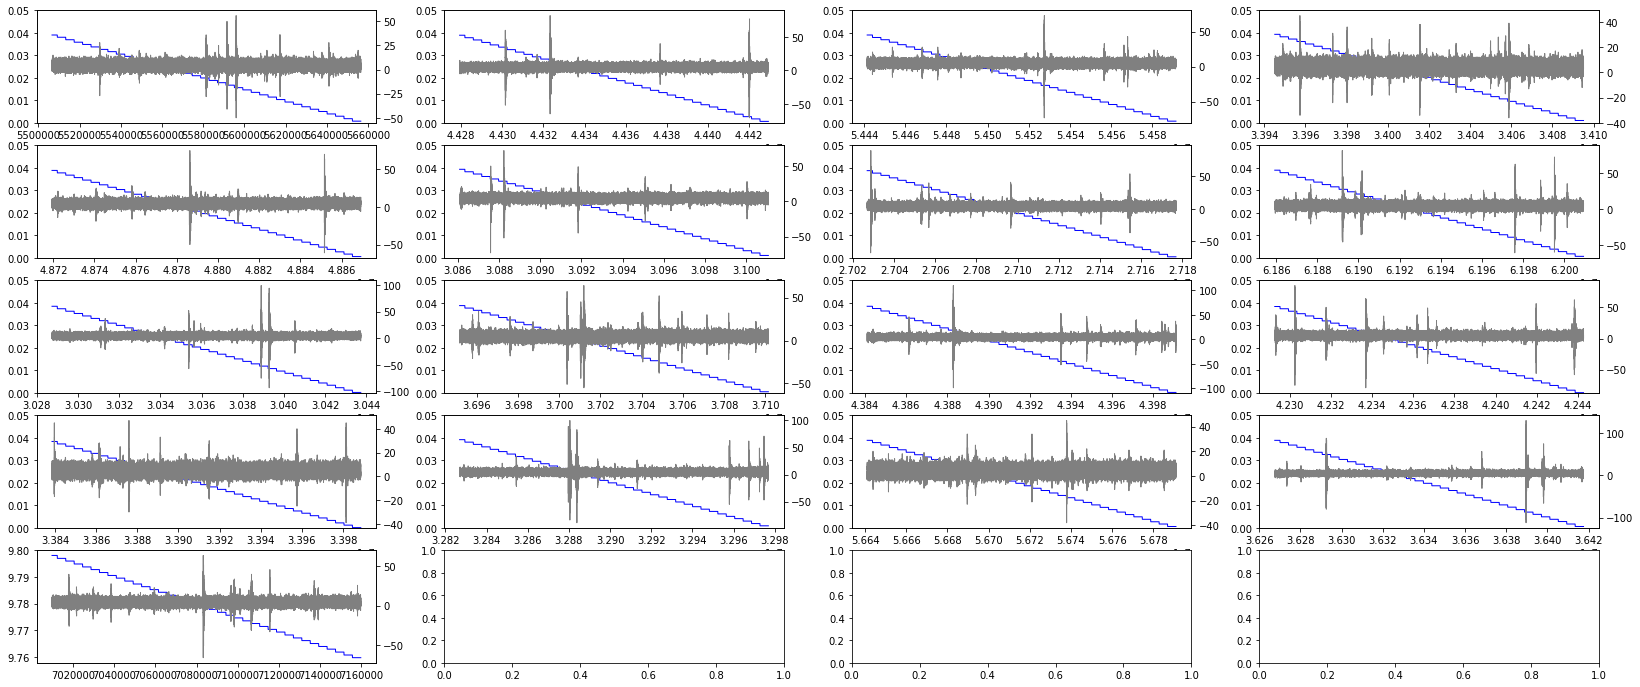

In [57]:
fig,axs = plt.subplots(5,4,figsize=(28,12), sharey=False)
n = -150_000
for (k,seq),ax in zip(sequenceDict.items(),axs.flatten()):
    if k < 16:
        ax.plot(seq['time_to_failure'][n:],lw=1,color='blue')
        ax.set_ylim(0,0.05)
        ax2  = ax.twinx()
        ax2.plot(seq['acoustic_data'][n:],lw=1,color='grey')
        
axs[4,0].plot(seq['time_to_failure'][n:],lw=1,color='blue')
ax2  = axs[4,0].twinx()
ax2.plot(seq['acoustic_data'][n:],lw=1,color='grey');

In [81]:
test = sequenceDict[0]
test1 = test[-150000:]
x = test1['acoustic_data']

In [82]:
def getSequenceSegments(sequenceDF,rows):
    segments = int(np.floor(sequenceDF.shape[0] / rows))
    return segments

In [83]:
getSequenceSegments(test,150000)

37

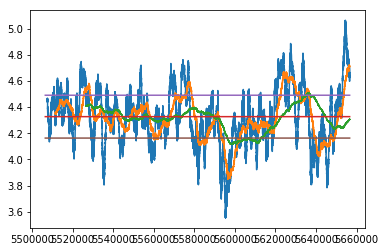

In [84]:
# plt.plot(x.index, x.values)
# plt.plot(x.index, [x.mean()]*len(x))
# plt.plot(x.index, ((x-x.mean())/x.std()).values)

for r in [1000,5000,20000,]:
    x.rolling(window=r,min_periods=r).mean().plot()
    
plt.plot(x.index, [x.mean()]*len(x))
plt.plot(x.index, [x.mean()+0.05*x.std()]*len(x))
plt.plot(x.index, [x.mean()-0.05*x.std()]*len(x))

In [96]:
def getFeatures(sequenceDF,seqID,getY=bool):
    acoustics = sequenceDF['acoustic_data'].copy()
    x = acoustics.values
    
    X_train = pd.DataFrame({'segID':seqID,
                            'ave':x.mean(),
                            'median':acoustics.median(),
                            'var':x.var(),
                            'std':x.std(),
                            'max':x.max().astype(float),
                            'min':x.min().astype(float),
                            'range': x.max().astype(float) - x.min().astype(float),
                            'total':abs(x).sum().astype(float), # total abs acoustic
                            'cumul':abs(x).cumsum().sum().astype(float),
                            'PoT05':len(x[(x >= x.mean()+0.5*x.std()) | (x <= x.mean()-0.5*x.std())])/len(x), # peaks over/under threshold (1*std)
                            'PoT1':len(x[(x >= x.mean()+1*x.std()) | (x <= x.mean()-1*x.std())])/len(x), # peaks over/under threshold (1*std))
                            'PoT2':len(x[(x >= x.mean()+2*x.std()) | (x <= x.mean()-2*x.std())])/len(x), # peaks over/under threshold (1*std)
                            'PoT3':len(x[(x >= x.mean()+3*x.std()) | (x <= x.mean()-3*x.std())])/len(x), # peaks over/under threshold (1*std)
                            'RDN1':float(len(x[abs(x)/abs(x).mean()>1])), # rainy day normal
                            'RDN2':float(len(x[abs(x)/abs(x).mean()>2])), # rainy day normal
                            'RDN3':float(len(x[abs(x)/abs(x).mean()>3])), # rainy day normal
                            'RDN4':float(len(x[abs(x)/abs(x).mean()>4])), # rainy day normal
                            'RDN8':float(len(x[abs(x)/abs(x).mean()>8])), # rainy day normal
                            'RDN10':float(len(x[abs(x)/abs(x).mean()>10])), # rainy day normal
                            'meanDiff':acoustics.diff().mean(), # change per step [max, median]
                            'stdDiff':acoustics.diff().std(), #  change per step [max, median]
                            'maxDiff':acoustics.diff().max(), #  change per step [max, median]
                            'Q001':np.quantile(x,0.001), # Quantile
                            'Q01':np.quantile(x,0.01), # Quantile
                            'Q05':np.quantile(x,0.05), # Quantile                        
                            'Q95':np.quantile(x,0.95), # Quantile
                            'Q99':np.quantile(x,0.99), # Quantile
                            'Q999':np.quantile(x,0.999), # Quantile
                            'Qrng5-95':np.subtract(*np.percentile(x, [95, 5])), # Quartile Range from 0.05 to 0.95% (range of values)
                            'Qrng10-90':np.subtract(*np.percentile(x, [90, 10])) # Quartile Range from 0.05 to 0.95% (range of values)
                           },index=[0])
    
    # IF so that we can re-use this later and not pass any y's
    if getY == True:
        y = sequenceDF['time_to_failure'].values[-1]
        y_train = pd.DataFrame({'segID':seqID,
                                'time_to_failure':y},index=[0])
        return X_train, y_train
    else:
        return X_train

In [97]:
getFeatures(test,99,getY=False)

,segID,ave,median,var,std,max,min,range,total,cumul,...,stdDiff,maxDiff,Q001,Q01,Q05,Q95,Q99,Q999,Qrng5-95,Qrng10-90
0,99,4.560983026121465,5.0,548.863608802824274,23.427838329705629,3252.0,-4621.0,7873.0,35185198.0,97168998187958.0,...,6.577056105206968,882.0,-69.0,-14.0,-3.0,12.0,24.0,79.0,15.0,10.0


In [98]:
# Create a training file with simple derived features
Xs = list()
ys = list()
rows = 150000
segID = 0

for seq in sequences:
    print(seq, end=',')
    sequenceDF = sequenceDict[seq].copy() # take copy of entire failure sequence
    nSegments = getSequenceSegments(sequenceDF,rows) # get number of 150,000 row segments per sequence
    
    for segment in range(nSegments):
        segDF = sequenceDF.iloc[segment*rows:segment*rows+rows].copy()
        xDF,yDF = getFeatures(segDF,segID,getY=True)
        segID+=1
        Xs.append(xDF)
        ys.append(yDF)
    
#     # manually add the last 150,000 to capture failure
#     segDF = sequenceDF[-rows:].copy()
#     xDF,yDF = getFeatures(segDF,segID)
#     segID+=1
#     X.append(xDF)
#     y.append(yDF)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,

In [129]:
X_train = pd.concat(Xs,sort=False).reset_index(drop=True)
y_train = pd.concat(ys,sort=False).reset_index(drop=True)

In [130]:
X_train.head()

,segID,ave,median,var,std,max,min,range,total,cumul,...,stdDiff,maxDiff,Q001,Q01,Q05,Q95,Q99,Q999,Qrng5-95,Qrng10-90
0,0,4.884113333333334,5.0,26.021110280488884,5.101089126891323,104.0,-98.0,202.0,836485.0,65908881756.0,...,3.395810224471091,32.0,-30.0,-8.0,-2.0,11.0,18.0,40.00000000000000,13.0,10.0
1,1,4.725766666666667,5.0,43.412309412222221,6.588801819164257,181.0,-154.0,335.0,860125.0,66025576390.0,...,3.675407476040564,78.0,-47.0,-11.0,-2.0,12.0,21.0,59.00000000000000,14.0,10.0
2,2,4.906393333333333,5.0,48.544297791955557,6.967373808828945,140.0,-106.0,246.0,922897.0,66426535142.0,...,3.755343042631861,47.0,-47.0,-15.0,-3.0,13.0,26.0,59.00000000000000,16.0,10.0
3,3,4.902240000000000,5.0,47.917989649066669,6.922282112791032,197.0,-199.0,396.0,890094.0,67391753310.0,...,3.707969343700410,68.0,-50.0,-12.0,-2.0,12.0,22.0,60.00099999998929,14.0,10.0
4,4,4.908720000000000,5.0,53.305854628266673,7.301085852684289,145.0,-126.0,271.0,916588.0,67425069281.0,...,3.661533206772217,43.0,-56.0,-15.0,-2.0,12.0,26.0,65.00000000000000,14.0,10.0


# Add Data Clusters

 - ## Choosing N Cluster
 - [Silhouette Score](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
 - [Cluster Score](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
### [KNN](https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/)
 - [sklearn doc](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [clustered regression](https://stats.stackexchange.com/questions/139042/ensemble-of-different-kinds-of-regressors-using-scikit-learn-or-any-other-pytho)

In [131]:
X = X_train.iloc[:,1:].copy(deep=True)
X.columns

Index(['ave', 'median', 'var', 'std', 'max', 'min', 'range', 'total', 'cumul',
       'PoT05', 'PoT1', 'PoT2', 'PoT3', 'RDN1', 'RDN2', 'RDN3', 'RDN4', 'RDN8',
       'RDN10', 'meanDiff', 'stdDiff', 'maxDiff', 'Q001', 'Q01', 'Q05', 'Q95',
       'Q99', 'Q999', 'Qrng5-95', 'Qrng10-90'],
      dtype='object')

In [132]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
#  scores = https://stackoverflow.com/questions/32370543/understanding-score-returned-by-scikit-learn-kmeans
from sklearn.cluster import KMeans

# silhoutte scoring
# https://stackoverflow.com/questions/51138686/how-to-use-silhouette-score-in-k-means-clustering-from-sklearn-library
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X)

silhouetteScores = list()
Kclusters = np.arange(2,21,1)

k_score = {}
for k in tqdm(Kclusters):
    KM = KMeans(n_clusters=k,
                init='k-means++',
                max_iter=300,
                n_init=25,
                n_jobs=-1)
    
    KM = KM.fit(X_train_scaled)
    k_score[k] = KM.score(X_train_scaled)
    
    preds = KM.fit_predict(X_train_scaled)
    centers = KM.cluster_centers_
    score = silhouette_score 
    silhouetteScores.append(silhouette_score(X_train_scaled, preds, metric='euclidean'))

100%|██████████| 19/19 [00:49<00:00,  3.44s/it]


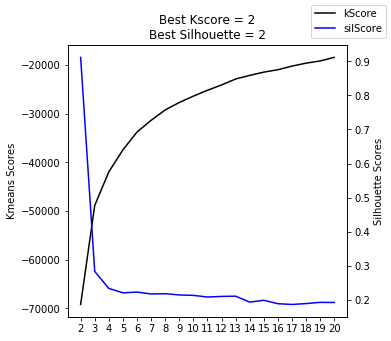

In [133]:
# interpret
fig,axs = plt.subplots(1,1,figsize=(5,5))

silScore = Kclusters[np.argmax(silhouetteScores)]
kScore = Kclusters[np.argmin([v for k,v in k_score.items()])]

axs.plot(k_score.keys(),k_score.values(), color='black', label='kScore');
axs.set_ylabel('Kmeans Scores')
axs.set_xticks(Kclusters)

ax2 = axs.twinx()
ax2.plot(Kclusters,silhouetteScores, color='blue', label='silScore');
ax2.set_ylabel('Silhouette Scores')

axs.set_title('Best Kscore = {}\n'\
              'Best Silhouette = {}'.format(kScore,silScore))
fig.legend();

In [134]:
# manual add another 
K = Kclusters[np.argmax(silhouetteScores)]
KM = KMeans(n_clusters=K,
            init='k-means++',
            max_iter=300,
            n_init=25,
            n_jobs=-1
           )
KM.fit(X_train_scaled)
X_train['Kmeans_{}'.format(K)] = KM.predict(X_train_scaled).astype(float)
X_train.head()

,segID,ave,median,var,std,max,min,range,total,cumul,...,maxDiff,Q001,Q01,Q05,Q95,Q99,Q999,Qrng5-95,Qrng10-90,Kmeans_2
0,0,4.884113333333334,5.0,26.021110280488884,5.101089126891323,104.0,-98.0,202.0,836485.0,65908881756.0,...,32.0,-30.0,-8.0,-2.0,11.0,18.0,40.00000000000000,13.0,10.0,0.0
1,1,4.725766666666667,5.0,43.412309412222221,6.588801819164257,181.0,-154.0,335.0,860125.0,66025576390.0,...,78.0,-47.0,-11.0,-2.0,12.0,21.0,59.00000000000000,14.0,10.0,0.0
2,2,4.906393333333333,5.0,48.544297791955557,6.967373808828945,140.0,-106.0,246.0,922897.0,66426535142.0,...,47.0,-47.0,-15.0,-3.0,13.0,26.0,59.00000000000000,16.0,10.0,0.0
3,3,4.902240000000000,5.0,47.917989649066669,6.922282112791032,197.0,-199.0,396.0,890094.0,67391753310.0,...,68.0,-50.0,-12.0,-2.0,12.0,22.0,60.00099999998929,14.0,10.0,0.0
4,4,4.908720000000000,5.0,53.305854628266673,7.301085852684289,145.0,-126.0,271.0,916588.0,67425069281.0,...,43.0,-56.0,-15.0,-2.0,12.0,26.0,65.00000000000000,14.0,10.0,0.0


### - [GMM Clustering ](https://www.datascience.com/blog/k-means-alternatives)
### - [GMM Sklearn](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html#sphx-glr-auto-examples-mixture-plot-gmm-covariances-py)
### - [Clustering with GMM](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html)

In [135]:
#Predict GMM cluster membership
from sklearn.mixture import GaussianMixture

GMMresults = {}
inst = {}
bic = []
n_components_range = Kclusters
cv_types = ['spherical', 'tied', 'diag', 'full']

for n_components in n_components_range:
    comp = {}
    for cv_type in cv_types:
        GMM = GaussianMixture(n_components=n_components,
                              covariance_type=cv_type,
                              max_iter=300,).fit(X_train_scaled)
        #GMM.predict(X)
        comp[cv_type] = GMM.bic(X_train_scaled)
        inst['{}_{}'.format(n_components,cv_type)] = GMM
        
    GMMresults[n_components] = comp

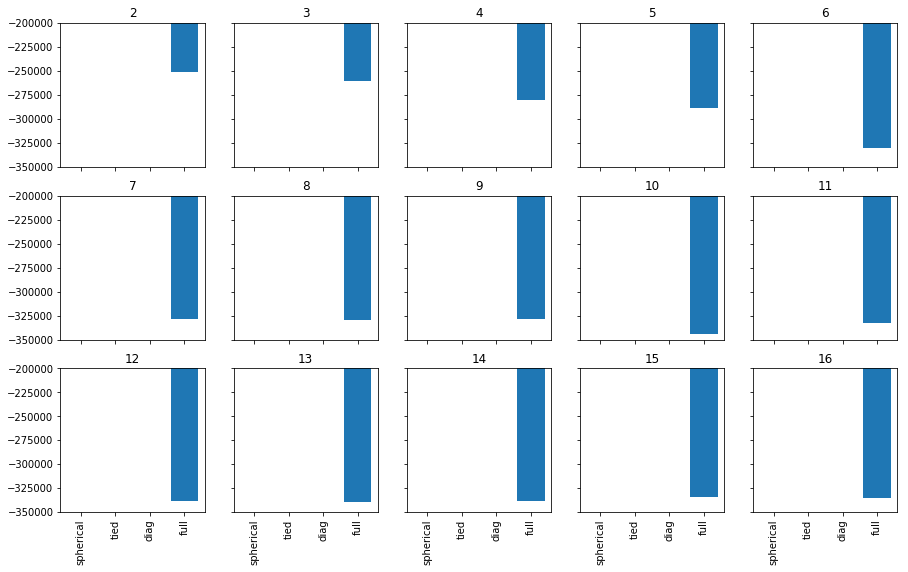

In [136]:
fig,axs = plt.subplots(3,5,figsize=(15,9),sharex=True,sharey=True)

for n_components,ax in zip(n_components_range,axs.flatten()):
    ax.bar([0,1,2,3],[v for (k,v) in GMMresults[n_components].items()])
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(['spherical', 'tied', 'diag', 'full'],rotation=90)
    ax.set_title(n_components)
    ax.set_ylim(-350000,-200000,)

In [137]:
gmm = 14
GMM = GaussianMixture(n_components=gmm,
                      covariance_type='full',
                      max_iter=300,).fit(X_train_scaled)

X_train['GMM_{}'.format(gmm)] = GMM.predict(X_train_scaled).astype(float)

In [138]:
X_train.dtypes

segID          int64
ave          float64
median       float64
var          float64
std          float64
max          float64
min          float64
range        float64
total        float64
cumul        float64
PoT05        float64
PoT1         float64
PoT2         float64
PoT3         float64
RDN1         float64
RDN2         float64
RDN3         float64
RDN4         float64
RDN8         float64
RDN10        float64
meanDiff     float64
stdDiff      float64
maxDiff      float64
Q001         float64
Q01          float64
Q05          float64
Q95          float64
Q99          float64
Q999         float64
Qrng5-95     float64
Qrng10-90    float64
Kmeans_2     float64
GMM_14       float64
dtype: object

# Feature Selection
- https://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/

### [Simple RFE](https://medium.com/@aneesha/recursive-feature-elimination-with-scikit-learn-3a2cbdf23fb7)
 - https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_digits.html#sphx-glr-auto-examples-feature-selection-plot-rfe-digits-py
 - https://www.kaggle.com/shrutigodbole15792/feature-selection
 - https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/

### [RFE Pipelines](https://stackoverflow.com/questions/32208546/combining-recursive-feature-elimination-and-grid-search-in-scikit-learn)
 - https://stackoverflow.com/questions/36683230/grid-search-with-recursive-feature-elimination-in-scikit-learn-pipeline-returns

In [139]:
from sklearn.feature_selection import RFE,RFECV
from sklearn.linear_model import LinearRegression

In [140]:
scaler = StandardScaler()
X = X_train.iloc[:,1:]
scaler.fit(X)
X_train_scaled = scaler.transform(X)

In [143]:
nFeatures = len(X.columns)

In [144]:
# create the RFE model and select attributes
estimator = LinearRegression()

rfeResults = dict()

for x in tqdm([x for x in range(2,nFeatures+1,1)]):
    rfe = RFE(estimator, n_features_to_select=x, step=1)
    rfe = rfe.fit(X_train_scaled, y_train.iloc[:,1].values.flatten())
    rfeResults[x] = rfe

100%|██████████| 31/31 [00:01<00:00, 24.53it/s]


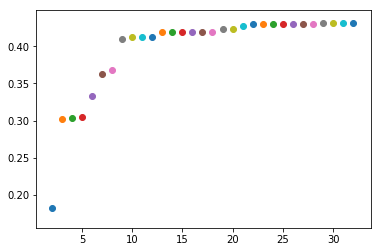

In [145]:
for k,v in rfeResults.items():
    # print summaries for the selection of attributes
    plt.scatter(k,v.score(X_train_scaled, y_train.iloc[:,1].values.flatten()))
    #print(v.support_)
    #print(v.ranking_)

In [156]:
rfeResults[25].support_

array([ True, False,  True,  True,  True,  True,  True,  True, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True, False, False])

In [157]:
X = X_train[X_train.iloc[:,1:].columns[rfeResults[25].support_]]
y = y_train.iloc[:,1].values.flatten()

# Train, Predict & Score
 - [notes on feature scaling](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html)

In [158]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, make_scorer

In [159]:
MAEscorer = make_scorer(mean_absolute_error, greater_is_better=False)
models = list()

### [NuSVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVR.html#sklearn.svm.NuSVR)

In [160]:
from sklearn.svm import NuSVR
pipe = Pipeline([('scaler', StandardScaler()),
                 ('pca',PCA()),
                 ('model', NuSVR())])

params = {'pca__n_components': [2,4,8,16],
          'model__kernel':['linear','rbf'],
          'model__nu': [0.5,0.75,0.9],
          'model__C': [1,2,2.5],
          'model__gamma': ['auto'],
          }

gs_NuSVR = GridSearchCV(estimator=pipe,
                        param_grid=params,
                        scoring=MAEscorer,
                        n_jobs=-1,
                        cv=3)

%time gs_NuSVR = gs_NuSVR.fit(X,y)
print('\n',gs_NuSVR.best_score_,'\n', gs_NuSVR.best_params_,)
models.append(gs_NuSVR)

CPU times: user 4.35 s, sys: 12.3 s, total: 16.6 s
Wall time: 25.4 s

 -2.1647744292114193 
 {'model__C': 1, 'model__gamma': 'auto', 'model__kernel': 'rbf', 'model__nu': 0.75, 'pca__n_components': 16}


### [XGBRegressor](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)

In [161]:
from xgboost import XGBRegressor
pipe = Pipeline([('scaler', StandardScaler()),
                 ('pca',PCA()),
                 ('model', XGBRegressor())])

params = {'pca__n_components': [4,8,12,16],
          'model__max_depth':[3,4,5,10],
          'model__learning_rate': [0.001,0.01,0.1],
          'model__n_estimators': [25,30,35,50],}

gs_XGB = GridSearchCV(estimator=pipe,
                      param_grid=params,
                      scoring=MAEscorer,
                      n_jobs=-1,
                      cv=3)

%time gs_XGB = gs_XGB.fit(X,y)
print('\n',gs_XGB.best_score_,'\n', gs_XGB.best_params_,)
models.append(gs_XGB)

CPU times: user 4.18 s, sys: 371 ms, total: 4.55 s
Wall time: 8.75 s

 -2.199921128251759 
 {'model__learning_rate': 0.1, 'model__max_depth': 4, 'model__n_estimators': 25, 'pca__n_components': 8}


### [Elasticnet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet)

In [162]:
from sklearn.linear_model import ElasticNet
pipe = Pipeline([('scaler', StandardScaler()),
                 ('pca',PCA()),
                 ('model', ElasticNet())])

params = {'pca__n_components': [2,4,8,16],
          'model__alpha':[0.5,1.0],
          'model__l1_ratio': [0.75,1.0],
          'model__max_iter': [1000],}

gs_EN = GridSearchCV(estimator=pipe,
                      param_grid=params,
                      scoring=MAEscorer,
                      n_jobs=-1,
                      cv=3)

%time gs_EN = gs_EN.fit(X,y)
print('\n',gs_EN.best_score_,'\n', gs_EN.best_params_,)
models.append(gs_EN)

CPU times: user 416 ms, sys: 43.4 ms, total: 460 ms
Wall time: 275 ms

 -2.3324802015207897 
 {'model__alpha': 0.5, 'model__l1_ratio': 0.75, 'model__max_iter': 1000, 'pca__n_components': 16}


# Plot Results and [Residuals](http://blog.minitab.com/blog/adventures-in-statistics-2/why-you-need-to-check-your-residual-plots-for-regression-analysis)

In [163]:
def plotResults(axis,model,title):
    global X_train,y_train
    y_act = y
    y_pred = model.best_estimator_.predict(X)
    score = mean_absolute_error(y_act, y_pred)
    
    axis.set_title('{}: {:.3f}'.format(title,score))
    axis.scatter(y_act,y_pred, s=0.5,color='blue')
    axis.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], lw=2,color='black')
    axis.set_xlim(0,20)
    axis.set_ylim(0,20)
    axis.set_xlabel('actual', fontsize=12)
    axis.set_ylabel('predicted', fontsize=12)

In [164]:
def plotResidual(axis,model,title):
    global X_train,y_train
    y_act = y
    y_pred = model.best_estimator_.predict(X)
    residuals = y_act - y_pred
    
    axis.set_title('Residuals')
    axis.scatter(y_pred,residuals,s=0.5,color='blue')
    axis.plot([0,20], [0,0], lw=2,color='black')
    axis.set_xlim(0,20)
    axis.set_ylim(-15,15)
    axis.set_xlabel('predicted', fontsize=12)
    axis.set_ylabel('residual', fontsize=12)

In [203]:
mean_absolute_error(y, (gs_NuSVR.best_estimator_.predict(X) + gs_XGB.best_estimator_.predict(X)) / 2.0)

2.0021205294949618

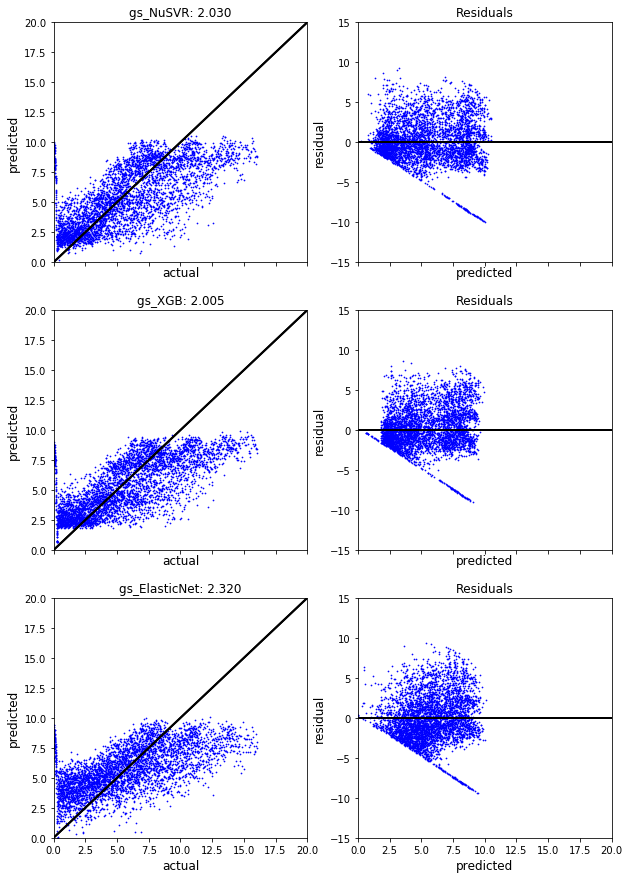

In [165]:
fig,axs = plt.subplots(3,2,figsize=(10,15), sharex=True)

for e,(mod,nm) in enumerate(zip([gs_NuSVR,gs_XGB,gs_EN],['gs_NuSVR','gs_XGB','gs_ElasticNet'])):
    plotResults(axs[e,0],mod,nm)
    plotResidual(axs[e,1],mod,nm)

# Predict on Test Data and Write Submission

In [166]:
submission = pd.read_csv(os.path.join(root,'sample_submission.csv'), index_col='seg_id')
submission.head()

,time_to_failure
seg_id,
seg_00030f,0
seg_0012b5,0
seg_00184e,0
seg_003339,0
seg_0042cc,0


In [202]:
with open(os.path.join(root,'d4.3_testData.pickle'),  'rb') as handle:
    segDict = pickle.load(handle)

X_tests = list()
for seg_id in tqdm(submission.index[:]):
    seg = segDict[seg_id]
    X_tests.append(getFeatures(seg,seg_id,getY=False))

100%|██████████| 2624/2624 [01:37<00:00, 26.99it/s]


In [168]:
X_test = pd.concat(X_tests).set_index(keys='segID',drop=True)

In [ ]:
X_test['Kmeans_{}'.format(K)] = KM.predict(X_test).astype(float)

In [ ]:
X_test['Kmeans_{}'.format(K2)] = KM2.predict(X_test.iloc[:,:-1]).astype(float)

In [170]:
X_test = X_test[[col for col in X]].copy()

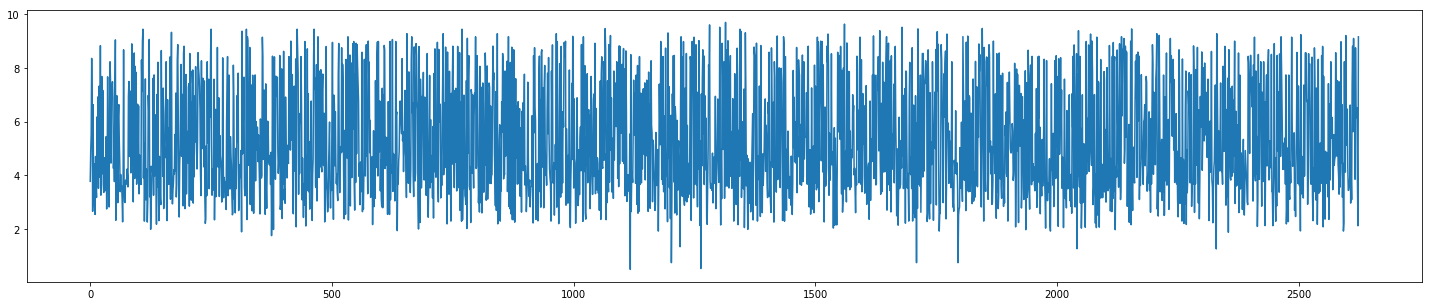

In [176]:
fig,axs = plt.subplots(1,1,figsize=(25,5))
plt.plot(gs_XGB.predict(X_test))
#plt.plot(gs_EN.predict(X_test))
#plt.plot(gs_NuSVR.predict(X_test))
#plt.plot((gs_XGB.predict(X_test)+gs_EN.predict(X_test)+gs_NuSVR.predict(X_test))/3.0);

In [191]:
submission['time_to_failure'] =  (gs_NuSVR.predict(X_test)+gs_XGB.predict(X_test))/2.0
print(len(submission))
submission.head()

2624


,time_to_failure
seg_id,
seg_00030f,4.075921688612713
seg_0012b5,5.092179651858084
seg_00184e,5.463920943736031
seg_003339,8.473539195534912
seg_0042cc,6.580170002995347


In [192]:
model='SVR_XGB_blend'

In [193]:
print('{}_{}_submission.csv'.format(version,model))
submission.to_csv(os.path.join(root,'{}_{}_submission.csv'.format(version,model)))

v4.3_SVR_XGB_blend_submission.csv


# v4.3_SVR is new best 1.502!

## next trials
 - dont remove any features.
 - use several [other regression models.](https://www.kaggle.com/miguelangelnieto/pca-and-regression/comments)